In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [14]:
class VisualBackbone(nn.Module):
    def __init__(self):
        super(VisualBackbone, self).__init__()
        
        # 1. Load Pretrained ResNet50
        # 'IMAGENET1K_V1' loads the standard weights trained on ImageNet
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # 2. Remove the Head (avgpool and fc)
        # ResNet components: [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc]
        # We want everything UP TO layer4.
        
        # We recreate the model as a Sequential block containing only the feature extractor parts
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # 3. Freeze the first 3 layers (and the stem)
        # We iterate through the named children to freeze specific blocks
        for name, child in self.backbone.named_children():
            if name in ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']:
                for param in child.parameters():
                    param.requires_grad = False
            
            # We leave 'layer4' with requires_grad = True so it can learn specific road features
            
    def forward(self, x):
        # x shape: [Batch, 3, Height, Width]
        features = self.backbone(x)
        return features

In [15]:
# --- TEST THE STEP 1 OUTPUT ---
if __name__ == "__main__":
    # Create the model
    visual_module = VisualBackbone()
    
    # Create a dummy image batch (ApolloScape/NuScenes images are usually large)
    # Batch Size=4, RGB=3, Height=512, Width=512
    # load actual image from sdd
    img_path= '../datasets/SDD/archive/annotations/bookstore/video0/reference.jpg'
    # open image
    img = Image.open(img_path).convert('RGB')
    # define transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    # apply transforms
    img_tensor = transform(img)
    # create batch
    dummy_input = img_tensor.unsqueeze(0).repeat(1, 1, 1, 1)  # Shape: [1, 3, 512, 512]
    
    # Pass through model
    output = visual_module(dummy_input)
    
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output features shape: {output.shape}")
    
    # Check if gradients are set correctly
    print("\nGradient Check:")
    print(f"Layer 1 (conv1) requires grad: {visual_module.backbone[0].weight.requires_grad}") # Should be False
    print(f"Layer 4 (bottleneck) requires grad: {visual_module.backbone[7][0].conv1.weight.requires_grad}") # Should be True

Input shape: torch.Size([1, 3, 512, 512])
Output features shape: torch.Size([1, 2048, 16, 16])

Gradient Check:
Layer 1 (conv1) requires grad: True
Layer 4 (bottleneck) requires grad: True


In [29]:
# visualise the tensor
def visualize_feature_map(feature_map, num_channels=6):
    # feature_map shape: [Batch, Channels, Height, Width]
    batch_size, channels, height, width = feature_map.shape
    
    # Select the first image in the batch
    feature_map = feature_map[0]  # shape: [Channels, Height, Width]
    
    # Create a grid for visualization
    fig, axes = plt.subplots(1, num_channels, figsize=(16, 8))
    
    for i in range(num_channels):
        if i < channels:
            ax = axes[i]
            ax.imshow(feature_map[i].detach().cpu(), cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Channel {i+1}')
    
    plt.show()


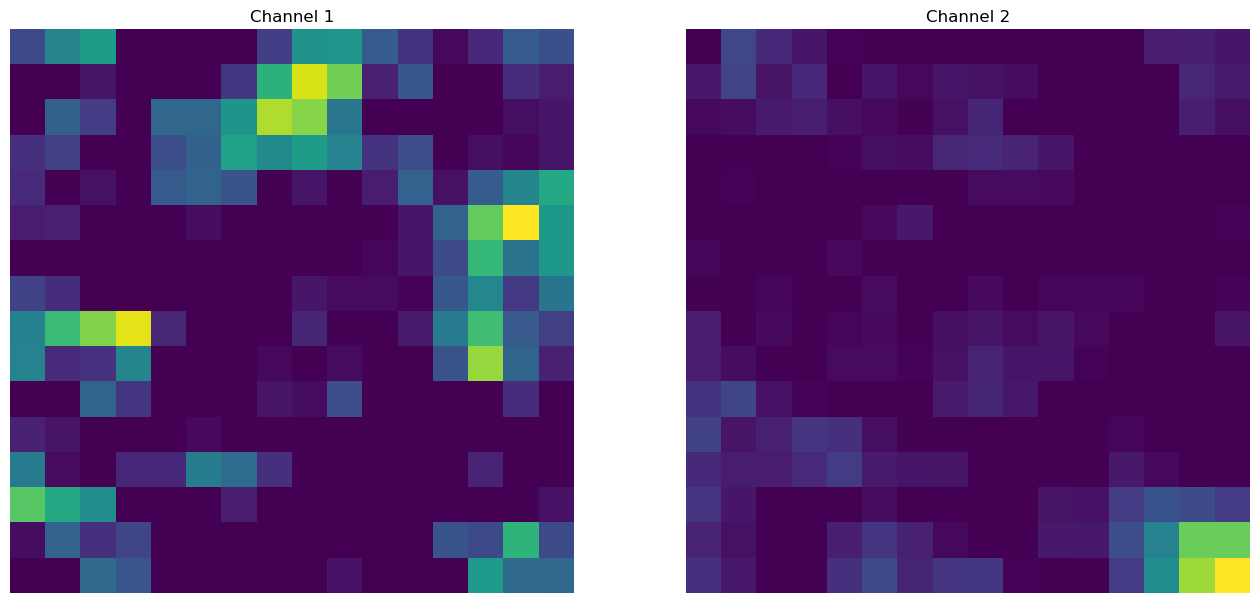

In [30]:
visualize_feature_map(output, num_channels=2)